# Imports

**General imports**

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fabio

In [3]:
import laueutils.peaks as peaks

# Goal of the notebook
There are cases where in each image we have two patterns closely aligned with each other.

Here is an example of a silicon substrate with a thin film of a mysterious material on top. 

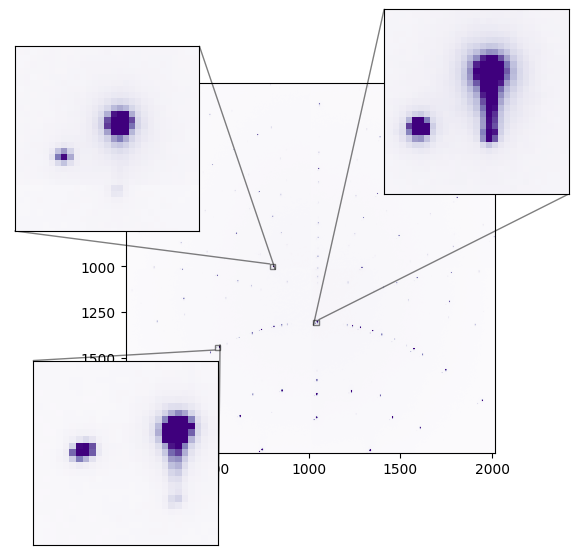

In [4]:
with fabio.open("double_pattern.tif") as image:
    image_data = image.data

fig, ax = plt.subplots()

ROIs = np.array([[1025, 1055, 1290, 1320],
                 [ 487,  515, 1428, 1456],
                 [ 786,  816,  986, 1016]])

inset_positions = np.array([[ 0.70,  0.70, 0.5, 0.5],
                            [-0.25, -0.25, 0.5, 0.5],
                            [-0.30,  0.60, 0.5, 0.5]])

ax.imshow(image_data, vmin=1000, vmax=3500, cmap='Purples')

for (x1,x2,y1,y2), (x0,y0,width,height) in zip(ROIs, inset_positions):
    
    inset = ax.inset_axes([x0, y0, width, height],
                           xlim=(x1, x2), ylim=(y1,y2),
                           xticks=[], yticks=[])
    
    inset.imshow(image_data,  vmin=1000, vmax=3500, cmap='Purples')
    inset.invert_yaxis()
    for spine in inset.spines.values(): # set border color of the insets
        spine.set_edgecolor('black')
    ax.indicate_inset_zoom(inset, edgecolor='black', linewidth=1)

The **goal** here will be to **separate the two patterns** in a way that can be confidently applied to an entire dataset.

Then the two peaklists will be saved to different files so that the indexing function can't make mistakes (if our peak positions are well fit :P).

For a quick estimate of the strain, a single peaksearch that gets both patterns in a single file will be sufficient, provided that we give the indexing function the orientation matrices of the two lattices, otherwise grain 0 is not guaranteed to be Si and grain 1 the mysterious material.

However, if we want to dig deeper into the information of a peak there are two sources of errors:

* the peaksearch can fail due to the closeness between the two patterns (and the fact that the Si reflections are more intense than those of InP)

* the indexing function can attach the Si [hkl] to the mystery material peak, thus the subsequent indexation of the next grain will not have that peak. Furthermore, the Si peak left behind will be too far from the expected position in the mystery material's pattern and it won't appear in its fit files (not that we would want it anyway, but still) 

And this is why I spend the time to surgically split them. If we particularly care about a single peak, as it was for the users of this experiment, we can fit only the intensity of that peak, as shown in the notebook on [ROI fitting](../ROI_fitting/ROI_fitting.ipynb) .

---
# Data location and metadata

In [5]:
data_folder = "path/to/data"
num_images  = 6561

In [6]:
scan_xsize,   scan_ysize   = 40, 40
scan_xpoints, scan_ypoints = 81, 81

**Scan points**

In [7]:
x, y = np.meshgrid(
    np.linspace(0, scan_xsize, scan_xpoints), 
    np.linspace(0, scan_ysize, scan_ypoints)
)

In [8]:
image_paths = [f"{data_folder}/img_{i:0>4d}.tif" for i in range(num_images)] # Modify

---

# Patterns simulations

## Crystal orientations
From the **detector calibration board** of the LaueTools GUI it's possible to extract the two orientation matrices.

In [9]:
substrate_orientation = np.array([[ 0.6525681194, 0.5334305,  0.538151194],
                                  [-0.0061545273, 0.7139228, -0.700197300],
                                  [-0.7577050687, 0.4536143,  0.469166316]])

mystery_m_orientation = np.array([[ 0.6493769732, 0.53057328,  0.54479494],
                                  [-0.0136951966, 0.72443863, -0.68920324],
                                  [-0.7603433357, 0.44009164,  0.47770007]])

## Read the calibration file

At this point you might want to read the calibration file with something like

```python
from LaueTools.IOLaueTools import readCalib_det_file

calibration_dictionary = readCalib_det_file("path/to/calibration.det")
calibration_parameters = dict_calib["CCDCalibParameters"]
pixel_size = dict_calib["pixelsize"]

for key, value in calibration_dictionary.items():
    print(f"{key: >18}: {value}")
```

Here I input manually the entries of the dictionary

In [10]:
calibration_dictionary = {
                "dd": 83.261,
              "xcen": 1053.24,
              "ycen": 1128.22,
              "xbet": -0.162,
              "xgam": 0.295,
         "pixelsize": 0.0734,
        "xpixelsize": 0.0734,
        "ypixelsize": 0.0734,
          "CCDLabel": "sCMOS",
          "framedim": [2018., 2016.],
  "detectordiameter": 148.1212,
      "kf_direction": "Z>0",
          "UB_calib": [0.4125557,  0.6343861, -0.6537218, -0.8326232,  0.5537125,  0.0118768, 0.3695084,  0.5394041,  0.7566418],
"CCDCalibParameters": [83.261, 1053.24, 1128.22, -0.162, 0.295]
}

In [11]:
print(
    "Calibration parameters\n\n", 
    calibration_parameters := calibration_dictionary["CCDCalibParameters"]
)

Calibration parameters

 [83.261, 1053.24, 1128.22, -0.162, 0.295]


## Run simulation

In [12]:
theo_substrate_peaks = peaks.simulate("Si",      substrate_orientation, calibration_parameters)
theo_mystery_m_peaks = peaks.simulate("mystery", mystery_m_orientation, calibration_parameters,
                                      # InP lattice parameterss are not defined in LaueTools,
                                      # defining a new materials dictionary with the params
                                      # is a workaround
                                      material_dictionary ={"mystery": ["mystery", [5.8686, 5.8686, 5.8686, 90, 90, 90], "dia"]})

## Visualize it

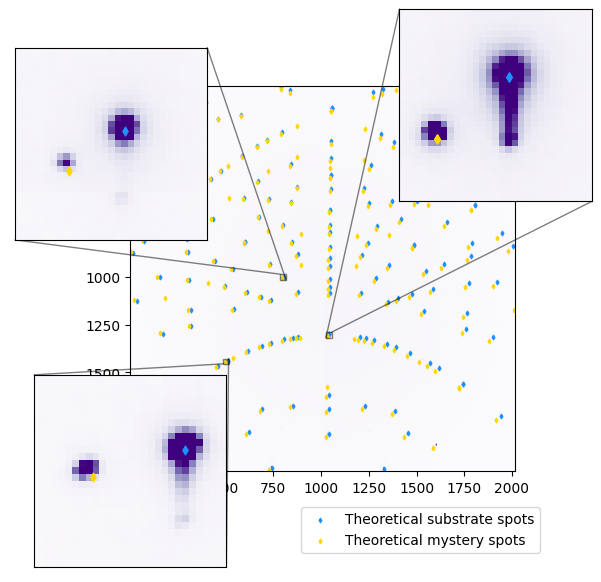

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ROIs = np.array([[1025, 1055, 1290, 1320],
                 [ 487,  515, 1428, 1456],
                 [ 786,  816,  986, 1016]])

inset_positions = np.array([[ 0.70,  0.70, 0.5, 0.5],
                            [-0.25, -0.25, 0.5, 0.5],
                            [-0.30,  0.60, 0.5, 0.5]])

# image_data comes from the initial plot with the insets
image = ax.imshow(image_data, vmin=1000, vmax=3500, cmap='Purples')
#visualization.draw_colorbar(image)
ax.scatter(theo_substrate_peaks[:,0], theo_substrate_peaks[:,1], s=5, marker='d', color='dodgerblue')
ax.scatter(theo_mystery_m_peaks[:,0], theo_mystery_m_peaks[:,1], s=5, marker='d', color='gold')

for (x1,x2,y1,y2), (x0,y0,width,height) in zip(ROIs, inset_positions):
    
    inset = ax.inset_axes([x0, y0, width, height],
                           xlim=(x1, x2), ylim=(y1,y2),
                           xticks=[], yticks=[], zorder=10000)
    
    inset.imshow(image_data,  vmin=1000, vmax=3500, cmap='Purples')
    inset.scatter(theo_substrate_peaks[:,0]-1, theo_substrate_peaks[:,1]-1, s=20, marker='d', color='dodgerblue')
    inset.scatter(theo_mystery_m_peaks[:,0]-1, theo_mystery_m_peaks[:,1]-1, s=20, marker='d', color='gold')
    inset.invert_yaxis()
    for spine in inset.spines.values(): # set border color of the insets
        spine.set_edgecolor('black')
    ax.indicate_inset_zoom(inset, edgecolor='black', linewidth=1)

fig.legend(['Theoretical substrate spots', 'Theoretical mystery spots'], loc=[0.5, 0.05])

# Peaksearch

In [24]:
from LaueTools.readmccd import PeakSearch
from LaueTools.IOLaueTools import writefile_Peaklist

The **technique** consists of finding all peaks and then splitting them in two by **computing the intersection between all the peaks experimentally found those expected, according to the simulation**.

In [25]:
def savepeaks(filepath, peaklist, prefix):
    fileindex = int(filepath.split("/")[-1].split("img_")[-1].split(".tif")[0])
    filename  = f"{prefix}_{fileindex:0>4d}"
    dirname   = os.getcwd()
    writefile_Peaklist(filename, peaklist, dirname=dirname)

In [21]:
def custom_peaksearch(filepath, verbose=False, split=True, save=True, **kwargs):
    all_peaks = []
    for i, boxsize in enumerate([15, 7]):
        result = PeakSearch(filepath, IntensityThreshold=100,
                            Data_for_localMaxima='auto_background',
                            boxsize=boxsize,
                            FitPixelDev=10,
                            PixelNearRadius=0.5,
                            PeakSizeRange=(0.1,20),
                            xtol=1e-3, **kwargs)
        
        if verbose:
            print(f"Peaksearch {i}: {len(result[0])} peaks found")
        all_peaks.append(result[0])
        
    all_peaks = peaks.remove_duplicates(np.vstack(all_peaks), tol=2)
    
    if split:
        substrate_peaks = peaks.intersect(all_peaks, theo_substrate_peaks, tol=2)
        mystery_m_peaks = peaks.intersect(all_peaks, theo_mystery_m_peaks,  tol=2)
        
        if verbose:
            print(f"Found {len(substrate_peaks)} substrate peaks",
                  f"Found {len(mystery_m_peaks)} mystery material peaks")
        if save:
            savepeaks(filepath, substrate_peaks, "substrate")
            savepeaks(filepath, mystery_m_peaks, "mystery_m")
        return substrate_peaks, mystery_m_peaks
        
    else:
        if verbose:
            print(f"Found {len(all_peaks)} unique peaks")
            
        if save:
            savepeaks(filepath, all_peaks, "allpeaks")
            
        return all_peaks

In [30]:
%matplotlib widget

----> Using fabio ... to open double_pattern.tif

----> Using fabio ... to open double_pattern.tif

----> Using fabio ... to open double_pattern.tif

----> Using fabio ... to open double_pattern.tif



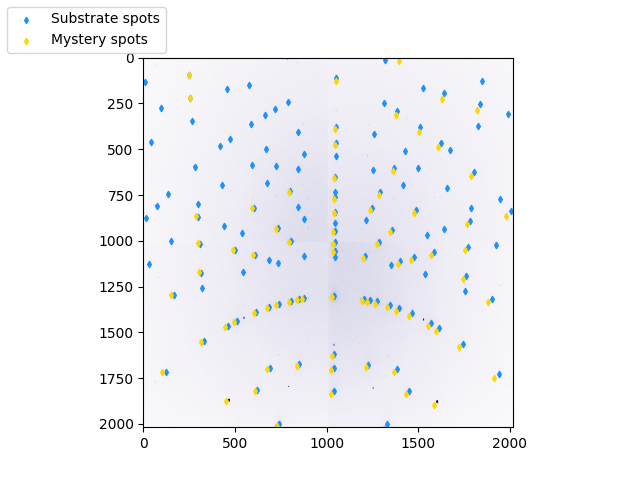

In [32]:
with fabio.open("double_pattern.tif") as image:
    image_data = image.data
    
all_peaks = custom_peaksearch("double_pattern.tif", save=False)

fig, ax = plt.subplots()
ax.imshow(image_data, vmin=1000, vmax=1500, cmap='Purples')
ax.scatter(all_peaks[0][:,0]-1, all_peaks[0][:,1]-1, s=10, color='dodgerblue', marker='d')
ax.scatter(all_peaks[1][:,0]-1, all_peaks[1][:,1]-1, s=10, color='gold', marker='d')
fig.legend(['Substrate spots', 'Mystery spots'], loc='upper left')

In [23]:
import multiprocessing as mp
from tqdm.notebook import tqdm

In [24]:
with mp.Pool(mp.cpu_count()) as pool:
    dataset = pool.starmap(custom_peaksearch, 
                           tqdm(zip(image_paths), total=len(image_paths), desc=f"Processing scan"),
                           chunksize=1)

Processing LARGE scan:   0%|          | 0/6561 [00:00<?, ?it/s]

In [22]:
from laueutils.visualization import draw_colorbar

In [ ]:
#Out of curiosity check if the central spot of mystery peaks is present in the entire dataset
mystery_peaks = [dataset[i][1] for i in range(len(dataset))]

res = peaks.track(mystery_peaks, (1031, 1310), tol=3)

fig, ax = plt.subplots()
image = ax.imshow(res[:,2].reshape(81,81), cmap='PuOr')
draw_colorbar.draw_colorbar(image)